In [3]:
!pip install transformers bert-score wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00


In [4]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [5]:
data_file_email = "/kaggle/input/dataspam/messages.csv"
data_file_sms = "/kaggle/input/dataspam/spam.csv"

In [6]:
# Use the 'error_bad_lines' parameter to skip bad lines
df_sms = pd.read_csv(data_file_sms, on_bad_lines='skip', engine="python", encoding='latin1')
df_email = pd.read_csv(data_file_email, on_bad_lines='skip', engine="python", encoding='latin1')

In [7]:
df_sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
df_email.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [9]:
df_sms.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df_email.drop(['subject'], axis=1, inplace=True)

In [10]:
df_sms.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)
df_email.rename(columns={'message': 'text', 'label': 'target'}, inplace=True)

In [11]:
df_email['target'] = df_email['target'].apply(lambda x: 'ham' if x == 0 else 'spam')

In [12]:
df_email = df_email[['target','text']]

In [13]:
df_sms['text_length'] = df_sms['text'].apply(len)
df_email['text_length'] = df_email['text'].apply(len)

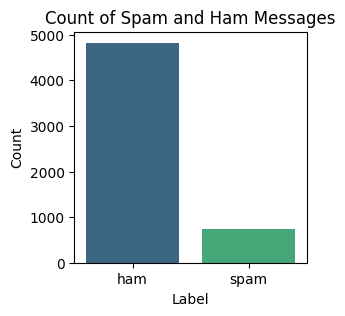

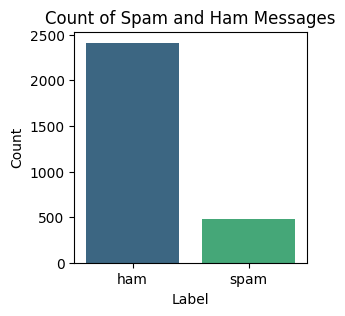

In [14]:
label_counts_sms = df_sms['target'].value_counts()
label_counts_email = df_email['target'].value_counts()

plt.figure(figsize=(3, 3))
sns.countplot(data=df_sms, x='target', palette='viridis', order=label_counts_sms.index)
plt.title("Count of Spam and Ham Messages")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(3, 3))
sns.countplot(data=df_email, x='target', palette='viridis', order=label_counts_email.index)
plt.title("Count of Spam and Ham Messages")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [15]:
df = pd.concat([df_sms, df_email], axis=0, ignore_index=True)
df

,target,text,text_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
8460,spam,hello thanks for stopping by ! ! we have taken...,262
8461,spam,"the list owner of : "" kiddin "" has invited you...",2163
8462,ham,"judging from the return post , i must have sou...",1039
8463,ham,gotcha ! there are two separate fallacies in t...,2949


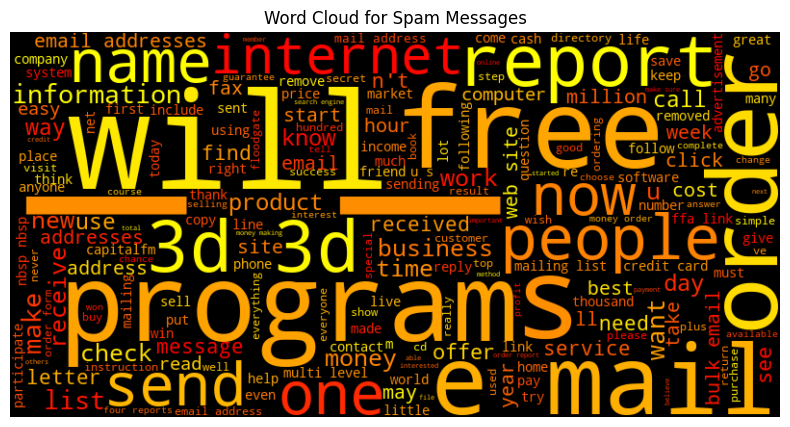

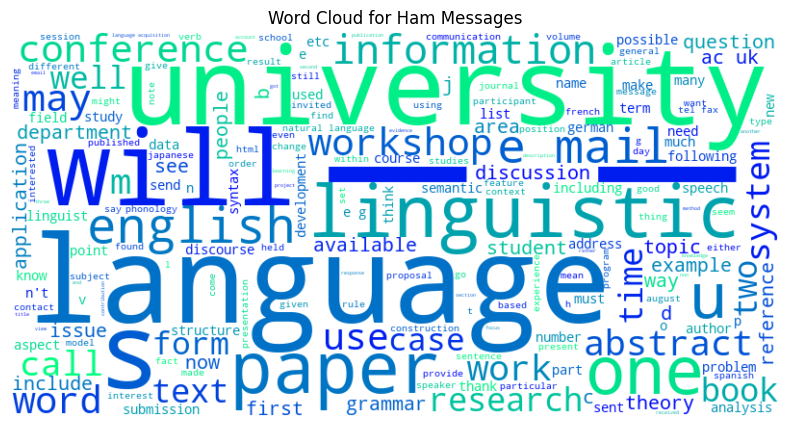

In [16]:
spam_text = " ".join(df[df['target'] == 'spam']['text'])
ham_text = " ".join(df[df['target'] == 'ham']['text'])

spam_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='autumn').generate(spam_text)
ham_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='winter').generate(ham_text)

plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Spam Messages")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Ham Messages")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

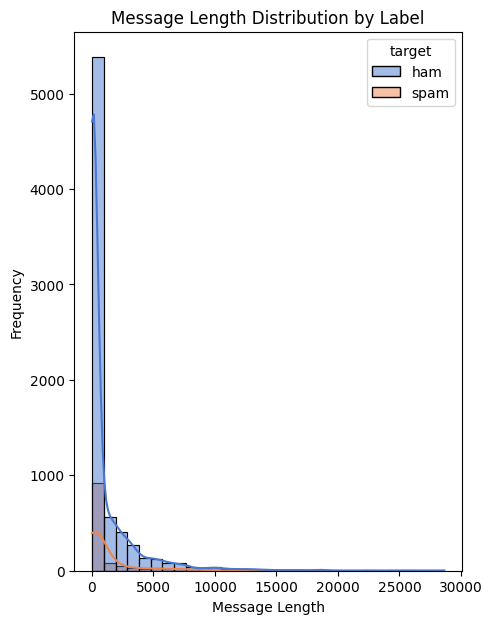

In [17]:
plt.figure(figsize=(5, 7))
sns.histplot(data=df, x='text_length', hue='target', bins=30, kde=True, palette='muted')
plt.title("Message Length Distribution by Label")
plt.xlabel("Message Length")
plt.ylabel("Frequency")
plt.show()

In [18]:
texts = df['text'].tolist()
labels = [1 if sentiment == "spam" else 0 for sentiment in df['target'].tolist()]

In [19]:
class SpamClassificationDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [20]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [21]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [22]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [23]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return "spam" if preds.item() == 1 else "ham"

In [24]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

In [25]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [26]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = SpamClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = SpamClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [28]:
print(device)

cuda


In [29]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/4
Validation Accuracy: 0.9911
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1437
           1       0.99      0.95      0.97       256

    accuracy                           0.99      1693
   macro avg       0.99      0.97      0.98      1693
weighted avg       0.99      0.99      0.99      1693

Epoch 2/4
Validation Accuracy: 0.9923
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1437
           1       0.98      0.97      0.97       256

    accuracy                           0.99      1693
   macro avg       0.99      0.98      0.98      1693
weighted avg       0.99      0.99      0.99      1693

Epoch 3/4
Validation Accuracy: 0.9923
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1437
           1       0.99      0.96      0.97       256

    accuracy                           0.99      1693
   macro avg  

In [31]:
torch.save(model.state_dict(), "bert_classifier.pth")

In [33]:
pip install sacremoses

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 17.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [34]:
from transformers import MarianMTModel, MarianTokenizer

def load_translation_model(src_lang, tgt_lang):
    model_name = f"Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}"
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    return tokenizer, model

# Load models for Arabic, French, and Spanish to English
arabic_to_english = load_translation_model("ar", "en")
french_to_english = load_translation_model("fr", "en")
spanish_to_english = load_translation_model("es", "en")


In [35]:
def translate_text(text, tokenizer, model, device):
    model.to(device)
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    translated_tokens = model.generate(**inputs)
    translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    return translated_text


In [36]:
from bert_score import score

def evaluate_translation(reference_text, translated_text):
    precision, recall, f1 = score([translated_text], [reference_text], lang="en")
    return f1.mean().item()


In [37]:
def predict_with_translation(text, src_lang, model, tokenizer, translation_models, device, max_length=128):
    # Select the appropriate translation model
    if src_lang == "ar":
        translator_tokenizer, translator_model = translation_models["ar"]
    elif src_lang == "fr":
        translator_tokenizer, translator_model = translation_models["fr"]
    elif src_lang == "es":
        translator_tokenizer, translator_model = translation_models["es"]
    else:
        raise ValueError(f"Unsupported source language: {src_lang}")

    # Translate the input text to English
    translated_text = translate_text(text, translator_tokenizer, translator_model, device)
    print(f"Translated Text: {translated_text}")

    # Evaluate translation quality using BERTScore
    bert_score = evaluate_translation(text, translated_text)
    print(f"BERTScore for translation: {bert_score:.4f}")

    if bert_score < 0.7:  # Adjust threshold as needed
        print("Translation quality is too low for reliable classification.")
        return "Translation Error"

    # Predict sentiment on the translated text
    return predict_sentiment(translated_text, model, tokenizer, device, max_length)

In [39]:
# Initialize the BERT classifier
bert_model_name = 'bert-base-uncased'
num_classes = 2  # Binary classification: spam or ham
model = BERTClassifier(bert_model_name, num_classes)

# Load pre-trained weights if available
model_path = "/kaggle/working/bert_classifier.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set the model to evaluation mode

/tmp/ipykernel_23/1125562414.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [42]:
# Prepare translation models
translation_models = {
    "ar": arabic_to_english,
    "fr": french_to_english,
    "es": spanish_to_english,
}

# Example usage
text = """
¡Has ganado un premio exclusivo! 🎉

Hola [Nombre del destinatario],

¡Felicidades! Tu correo ha sido seleccionado como el gran ganador de nuestro sorteo mensual.

Premio: $10,000 USD en efectivo
Reclama tu premio ahora: Haz clic en el siguiente enlace para confirmar tus datos y recibir tu premio de inmediato:

👉 Haz clic aquí para reclamar tu premio

Pero date prisa, esta oferta especial expira en las próximas 24 horas.

Atentamente,
Equipo de Premios Exclusivos

P.D.: Este es un mensaje importante, por favor no lo ignores.
"""
src_lang = "es"
result = predict_with_translation(text, src_lang, model, tokenizer, translation_models, device)
print(f"Prediction: {result}")


Translated Text: You have won an exclusive prize!  Hello [Name of recipient], Congratulations! Your mail has been selected as the great winner of our monthly draw. Prize: $10,000 USD in cash Claim your prize now: Click on the link below to confirm your data and receive your prize immediately:  Click here to claim your prize But hurry, this special offer expires within the next 24 hours. Sincerely, Exclusive Awards Team P.D.: This is an important message, please don't ignore it.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore for translation: 0.8239
Prediction: spam
